<a href="https://colab.research.google.com/github/SiraDD/Monte-Carlo-Options/blob/main/Pair_trading_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 11.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import datetime
import matplotlib.pyplot as plt
import yfinance as yfin
yfin.pdr_override()

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

In [2]:
symbol_list = ['MA', 'V']
endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days=1000)
df = pdr.get_data_yahoo(symbol_list, startDate, endDate).tz_localize(None)['Close']
#df.columns = map(lambda x: x.symbol, df.columns)
X1 = df[symbol_list[0]]
X2 = df[symbol_list[1]]

[*********************100%***********************]  2 of 2 completed


Text(0, 0.5, 'Series value')

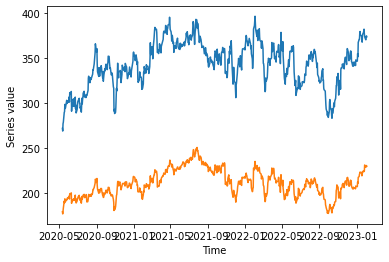

In [3]:
plt.plot(X1.index,X1.values)
plt.plot(X2.index,X2.values)
plt.xlabel('Time')
plt.ylabel('Series value')

In [4]:
X1 = sm.add_constant(X1)
results = sm.OLS(X2,X1).fit()
X1 = X1[symbol_list[0]]
results.params

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


const    32.412314
MA        0.520968
dtype: float64

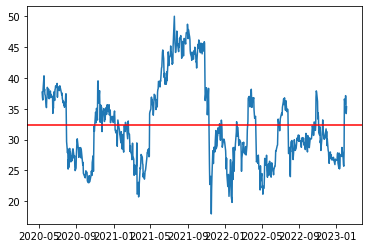

In [5]:
b = results.params[symbol_list[0]]
Z = X2 - b*X1
Z.name = 'Z'
plt.plot(Z.index,Z.values)
plt.axhline(Z.values.mean(), color='red')

Test for cointegration

In [6]:
score, p_value, _ = coint(X1,X2)
p_value

0.05231895361721692

In [7]:
def zscore(series):
  return (series - series.mean()) / np.std(series)

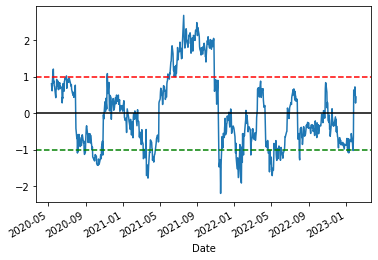

In [8]:
zscore(Z).plot()
plt.axhline(zscore(Z).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')

Rolling average to prevent lookahead bias

In [9]:
from statsmodels.regression.rolling import RollingOLS
rolling_beta = RollingOLS(X2, X1, window=30).fit()
rbeta = rolling_beta.params
rbeta = rbeta[symbol_list[0]]
rbeta

Date
2020-05-12         NaN
2020-05-13         NaN
2020-05-14         NaN
2020-05-15         NaN
2020-05-18         NaN
                ...   
2023-01-30    0.597057
2023-01-31    0.597795
2023-02-01    0.598469
2023-02-02    0.598905
2023-02-03    0.599486
Name: MA, Length: 689, dtype: float64

NameError: ignored

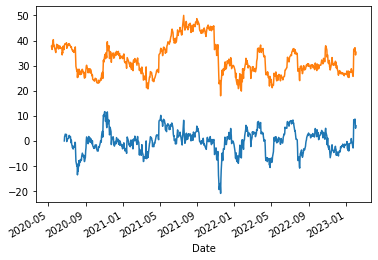

In [12]:
spread = X2 - rbeta*X1
plt.plot(spread.index, spread.values)
Z.plot()

#spread_mavg1 = pd.rolling_mean(spread, window=1)
spread_mavg1.name = 'spread 1d mavg'
#spread_mavg30 = pd.rolling_mean(spread, window=30)
spread_mavg30.name = 'spread 30d mavg'